#Install libraries

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218921 sha256=53a3a495522bc1f7c1a7291aa724545c54aabe878a6056b8607211f2d7d8a5c3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


#Classification On Stocks based on Closing Price Derivatives

##Calculate features

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import pandas_ta as pta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
df = pdr.get_data_yahoo("IBM", start="1980-02-01", end="2019-07-13")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df_close = df
df_close

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-02-01,16.401770,16.610899,16.342016,16.581022,4.950254,1513353
1980-02-04,16.581022,16.640774,16.401770,16.521273,4.932418,1205829
1980-02-05,16.521273,16.640774,16.431644,16.640774,4.968098,1595778
1980-02-06,16.491396,16.491396,16.192638,16.342016,4.939918,2133003
1980-02-07,16.312141,16.312141,16.043261,16.043261,4.849611,2145555
...,...,...,...,...,...,...
2019-07-08,134.847031,135.076477,134.101334,134.388138,111.771965,2505484
2019-07-09,134.426392,134.789673,133.011475,133.202682,110.786003,3519999
2019-07-10,133.843216,135.669220,133.642441,134.292542,111.692444,2629539


In [ ]:
df_close['EWMA15'] = df_close['Close'].ewm(span=5).mean()
df_close['EWMA15_pct'] = df_close['EWMA15'].pct_change()*100
# df_close['EWMA20'] = df_close['Close'].ewm(span=20).mean()
# df_close['EWMA50'] = df_close['Close'].ewm(span=50).mean()
# df_close['RSI7'] = pta.rsi(df['Close'], length = 7)
# df_close['RSI14'] = pta.rsi(df['Close'], length = 14)
# df_close['RSI20'] = pta.rsi(df['Close'], length = 20)

# delta = df_close['Close'].diff(1)
# delta = delta.dropna()
# up = delta.copy()
# down = delta.copy()
# up[up<0] = 0
# down[down>0] = down
# df_close['up'] = up
# df_close['down'] = down

#Intraday difference
df_close['diff'] = ((df_close['Close'] - df_close['Open'])/df_close['Open'])*100

In [ ]:
#Create target to determine if tomorrow's price would be greater than today's price
#Interday difference
df_close['target'] = np.where(df_close['Open'].shift(-1)>df_close['Close'], 1, 0)

In [ ]:
df_close

,Open,High,Low,Close,Adj Close,Volume,EWMA15,EWMA15_pct,diff,target
Date,,,,,,,,,,
1980-02-01,16.401770,16.610899,16.342016,16.581022,4.950254,1513353,16.581022,NaN,1.092886,0
1980-02-04,16.581022,16.640774,16.401770,16.521273,4.932418,1205829,16.545173,-0.216210,-0.360349,0
1980-02-05,16.521273,16.640774,16.431644,16.640774,4.968098,1595778,16.590457,0.273704,0.723317,0
1980-02-06,16.491396,16.491396,16.192638,16.342016,4.939918,2133003,16.487259,-0.622036,-0.905804,0
1980-02-07,16.312141,16.312141,16.043261,16.043261,4.849611,2145555,16.316814,-1.033797,-1.648348,0
...,...,...,...,...,...,...,...,...,...,...
2019-07-08,134.847031,135.076477,134.101334,134.388138,111.771965,2505484,134.327985,0.022395,-0.340306,1
2019-07-09,134.426392,134.789673,133.011475,133.202682,110.786003,3519999,133.952884,-0.279242,-0.910319,1
2019-07-10,133.843216,135.669220,133.642441,134.292542,111.692444,2629539,134.066103,0.084522,0.335710,1


##Create Dataset, Scale and create Training and Testing Split

In [ ]:
buffer_df = df_close[['EWMA15_pct', 'diff']]

In [ ]:
df_combined = buffer_df[1:]

In [ ]:
df_combined

,EWMA15_pct,diff
Date,,
1980-02-04,-0.216210,-0.360349
1980-02-05,0.273704,0.723317
1980-02-06,-0.622036,-0.905804
1980-02-07,-1.033797,-1.648348
1980-02-08,-0.545716,0.186214
...,...,...
2019-07-08,0.022395,-0.340306
2019-07-09,-0.279242,-0.910319
2019-07-10,0.084522,0.335710


In [ ]:
import math

#Split the data

training_data_len = math.ceil( len(df_combined) *.8)
df_for_training = df_combined.iloc[:training_data_len,:]
# target_for_training = df_target.iloc[:training_data_len]
df_for_testing = df_combined.iloc[training_data_len:,:]
# target_for_testing = df_target.iloc[training_data_len:]

#Scale the data
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_combined_training_scaled = scaler.transform(df_for_training)
df_combined_training_scaled = pd.DataFrame(df_combined_training_scaled)


In [ ]:
trainX = []
trainY = []
n_future = 1  # Number of days we want to predict into the future

n_past = 30
for i in range(n_past, len(df_combined_training_scaled)):
     trainX.append(df_combined_training_scaled.iloc[i - n_past:i, 0:df_for_training.shape[1]])
     trainY.append(df_combined_training_scaled.iloc[i,0])

trainX, trainY = np.array(trainX), np.array(trainY)
print(trainX.shape, trainY.shape)

(7926, 30, 2) (7926,)


In [ ]:
from keras import Model
from keras.layers import Layer
from keras.layers import Input, Dense
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
#With 2 layers LSTM1: 100 LSTM2: 50, loss is: Epoch 10/10 (Both have relu activation)
# 2316/2316 - 10s - loss: 0.9265 - val_loss: 0.2438 - 10s/epoch - 4ms/step
#WIth 1 layer LSTM: 100 Epoch 10/10 (relu activation)
# 2316/2316 - 11s - loss: 0.9221 - val_loss: 0.2451 - 11s/epoch - 5ms/step
#With 2 layers, LSTM1:100 LSTM2: 50 loss is: Epoch 10/10 (tanh on dense layer)
# 2316/2316 - 10s - loss: 0.7187 - val_loss: 0.1549 - 10s/epoch - 4ms/step
# With 2 layers, LSTM1: 100 LSTM2: 50 Epoch 10/10 (activation tanh on dense)
# 2316/2316 - 8s - loss: 0.7108 - val_loss: 0.1523 - 8s/epoch - 4ms/step

In [ ]:
import keras

def create_LSTM_with_attention(hidden_units, dense_units):
    x=Input(shape=(trainX.shape[1:]))
    conv_x = keras.layers.Conv1D(30, 3, activation='relu')(x)
    attention_layer = attention()(conv_x)
    print(attention_layer.shape, attention_layer)
    dropout_lstm = keras.layers.Dropout(.2)(attention_layer)
    reshaped_attention = keras.layers.Reshape((30,1), input_shape=(30,))(dropout_lstm)
    batchnorm_reshaped_attention = keras.layers.BatchNormalization()(reshaped_attention)
    lstm_layer = LSTM(100, return_sequences=True, activation='relu')(batchnorm_reshaped_attention)
    lstm_layer = LSTM(50, return_sequences=False, activation='relu')(lstm_layer)
    outputs=Dense(1, trainable=True, activation='tanh')(lstm_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')
    return model

# Create the model with attention, train and evaluate
model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

model_attention.summary()

model_attention.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2, validation_split=0.2)

(None, 30) KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), name='attention_1/Sum:0', description="created by layer 'attention_1'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 2)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 30)            210       
                                                                 
 attention_1 (attention)     (None, 30)                58        
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 reshape_1 (Reshape)         (None, 30, 1)             0         
                                                                 
 batch_normalization_1 (Bat

In [ ]:
# def create_LSTM_with_attention(hidden_units, dense_units):
#     x=Input(shape=(trainX.shape[1:]))
#     lstm_layer = LSTM(hidden_units, return_sequences=True, activation='relu')(x)
#     attention_layer = attention()(lstm_layer)
#     outputs=Dense(1, trainable=True, activation='tanh')(attention_layer)
#     model=Model(x,outputs)
#     model.compile(loss='mse', optimizer='adam')
#     return model

# # Create the model with attention, train and evaluate
# model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

# model_attention.summary()

# model_attention.fit(trainX, trainY, epochs=20, batch_size=32, verbose=2, validation_split=0.2)

In [ ]:
df_combined_testing_scaled = scaler.transform(df_for_testing)
df_combined_testing_scaled = pd.DataFrame(df_combined_testing_scaled)


In [ ]:
testX = []
testY = []
n_future = 1  # Number of days we want to predict into the future

n_past = 30
for i in range(n_past, len(df_combined_testing_scaled)):
     testX.append(df_combined_testing_scaled.iloc[i - n_past:i, 0:df_for_testing.shape[1]])
     testY.append(df_combined_testing_scaled.iloc[i,0])

testX, testY = np.array(testX), np.array(testY)
print(testX.shape, testY.shape)

(1959, 30, 2) (1959,)


62/62 [==============================] - 1s 15ms/step


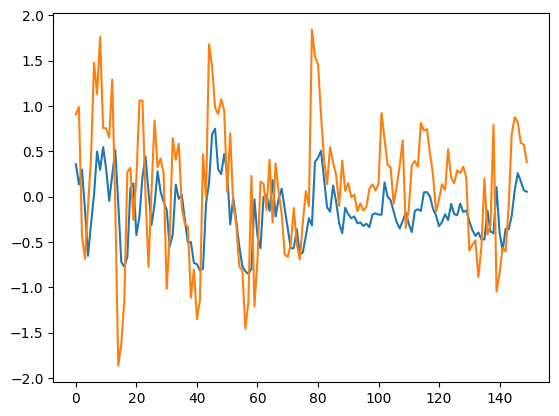

In [ ]:
import matplotlib.pyplot as plt

pred = model_attention.predict(testX)

plt.plot(pred[:150])
plt.plot(testY[:150])

In [ ]:
model_attention.evaluate(testX, testY)

62/62 [==============================] - 1s 16ms/step - loss: 0.3907


0.39073294401168823